In [30]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import stats

# Case 3: Numéraires in a Binomial Tree & Monte Carlo

## Part 1: Numéraires in binomial Tree

In [31]:
r = 0.01       
sigma = 0.15   
T = 10          
t = 0          
n = 100
guarantee = 100
S0 = 100

In [3]:
def binomialTree_ORIGINAL(r, sigma, T, guarantee, n):

    dt = T / n
    R_dt = np.exp(r * dt)

    u = R_dt * np.exp(sigma * np.sqrt(dt))
    d = R_dt * np.exp(- sigma * np.sqrt(dt))
    
    p = (R_dt - d) / (u - d)
    q = 1 - p

    # Stock price 
    stockValues = 100 * u**np.arange(n + 1) * d**(n - np.arange(n + 1))

    # option prices
    contractPrice = np.maximum(stockValues, guarantee)

    for i in np.arange(n,0,-1):
        contractPrice = (1/R_dt) * (p * contractPrice[1:i+1] + q * contractPrice[0:i])

    return contractPrice[0]

option_price = binomialTree_ORIGINAL(r, sigma, T, guarantee, n)
print("Option Price normal Binomial Model:", option_price)

Option Price normal Binomial Model: 113.45806426770127


In [ ]:
# CASE 1: Numeraire = Bank Account

def binomialTree_BankNum(r, sigma, T, guarantee, n):
    dt = T / n
    R_dt = np.exp(r * dt)

    u = R_dt * np.exp(sigma * np.sqrt(dt))
    d = R_dt * np.exp(-sigma * np.sqrt(dt))
    
    # probability with bank as numéraire
    p_star = (R_dt - d) / (u - d)

    # bank account values
    BankValue = 100 * R_dt ** np.arange(n + 1)

    # Stock prices
    stockValues = 100 * u**np.arange(n + 1) * d**(n - np.arange(n + 1))

    # option prices 
    contractPrice = np.maximum(stockValues, guarantee)

    for i in np.arange(n, 0, -1):
        contractPrice = ((p_star * contractPrice[1:i+1] + (1 - p_star) * contractPrice[0:i] ) / BankValue[i]) * BankValue[i-1]

    return contractPrice[0]

In [46]:
# CASE 1: Numeraire = Bank Account

def binomialTree_BankNum(r, sigma, T, guarantee, n):
    dt = T / n
    R_dt = np.exp(r * dt)

    u = R_dt * np.exp(sigma * np.sqrt(dt))
    d = R_dt * np.exp(-sigma * np.sqrt(dt))
    
    # Adjusted probability with bank as numéraire
    p_star = (R_dt - d) / (u - d)
    numMaturity = np.exp(r * T)


    # bank account values
    BankValue = 100 * R_dt ** np.arange(n + 1)

    # Stock prices
    stockValues = 100 * u**np.arange(n + 1) * d**(n - np.arange(n + 1))

    # option prices 
    contractPrice = np.maximum(stockValues, guarantee)/numMaturity

    for i in np.arange(n, 0, -1):
        contractPrice = (p_star * contractPrice[1:i+1] + (1 - p_star) * contractPrice[0:i] )

    return contractPrice[0]

In [47]:
price = binomialTree_BankNum(r, sigma, T, guarantee, n) 
print("Option Price with bank account as numéraire:", price)

Option Price with bank account as numéraire: 113.45806426770213


In [ ]:
def binomialTree_StockAsNumeraire(r, sigma, T, guarantee, n):
    dt = T / n
    R_dt = np.exp(r * dt)

    u = R_dt * np.exp(sigma * np.sqrt(dt))
    d = R_dt * np.exp(-sigma * np.sqrt(dt))

    p_star = ((R_dt - d) * u) / ((u - d) * R_dt)

    # Stock price 
    stockValues = 100 * u**np.arange(n + 1) * d**(n - np.arange(n + 1))

    # option prices 
    contractPrice = np.maximum(stockValues, guarantee)

    for i in np.arange(n, 0, -1):
        contractPrice = (p_star * contractPrice[1:i+1] / stockValues[1:i+1] + 
                         (1 - p_star) * contractPrice[0:i] / stockValues[0:i]) * (stockValues[1:i+1] / u)

    return contractPrice[0]

In [42]:
def binomialTree_StockAsNumeraire(r, sigma, T, guarantee, n):
    dt = T/n
    R_dt = np.exp(r * dt)

    u = R_dt * np.exp(sigma * np.sqrt(dt))
    d = R_dt * np.exp(-sigma * np.sqrt(dt))


    pstar1 = ((R_dt-d)*R_dt) / ((u-d)*R_dt)
    pstar2 = ((u-R_dt)*R_dt) / ((u-d)*R_dt)

    # Stock price 
    stock = 100 * u ** np.arange(0,n+1,1) * d ** np.arange(n,-1,-1)

    # option prices 
    contractPrice = np.maximum(guarantee, stock)

    for i in np.arange(n,0,-1):
        contractPrice = (pstar1 * contractPrice[1:i+1] + pstar2 * contractPrice[0:i]) / R_dt

    return contractPrice[0]

In [48]:
price = binomialTree_StockAsNumeraire(r, sigma, T, guarantee, n)
print("Option Price with Stock as numéraire:", price)

Option Price with Stock as numéraire: 113.45806426770045


Comapre for diff time steps!!! maybe up to 1 000 000 

## Part 2: Monte Carlo Simulation

In [4]:
r = 0.01       
sigma = 0.15   
T = 10          
t = 0          
n = 100
K = 100
S0 = 100
N = 10
M = 100000

In [5]:
def MonteCarloSimulation(S0, T, r, sigma, N, M, K):
    np.random.seed(30)

    dt = T / N
    
    # computing Stock prices
    stockPrices = np.zeros(M)
    
    # Monte Carlo simulation
    for i in range(M):
        x = S0  
        for t in range(N):
            epsilon = np.random.normal(0, 1)  # Random standard normal variable
            x *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * epsilon)  # Update price
        stockPrices[i] = x  # Store final price
    
    # Calculate the expected payoff with guarantee
    optionPrice = np.maximum(stockPrices, K)
    
    # Discount the expected payoff to get the contract price
    optionPrice = np.exp(-r * T) * np.mean(optionPrice)
    
    
    return optionPrice

optionPrice = MonteCarloSimulation(S0, T, r, sigma, N, M, K)
print("Price of the UL Contract:", optionPrice)

# Price of the UL Contract M = 100 000: 113.54369591297512
# Price of the UL Contract M = 1 000 000: 113.54369591297512


Price of the UL Contract: 113.55626126248505


In [ ]:
def MonteCarloSimulationWithSE(S0, T, r, sigma, N, M, guarantee):
    np.random.seed(30)

    dt = T / N
    x0 = S0
    
    # Compute stock prices
    stockPrices = np.zeros(M)
    
    # Monte Carlo simulation
    for i in range(M):
        x = x0  
        for t in range(N):
            epsilon = np.random.normal(0, 1)  # Random standard normal variable
            x *= np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * epsilon)  # Update price
        stockPrices[i] = x  # Store final price
    
    # Calculate the expected payoff with guarantee
    optionPrice = np.maximum(stockPrices, guarantee)
    
    # Discount the expected payoff
    optionPrice = np.exp(-r * T) * np.mean(optionPrice)
    
    # Calculate the standard error
    variance = np.var(optionPrice, ddof=1)
    SE = np.sqrt(variance / M)
    
    print("Price of the UL Contract:", optionPrice)
    print("Standard Error:", SE)
    print("Price of the UL Contract ± SE:", optionPrice, "±", SE)
    
    return optionPrice, SE

# Example usage
S0 = 100  # Example initial stock price
T = 1     # Example time to maturity in years
r = 0.05  # Example risk-free rate
sigma = 0.2  # Example volatility
N = 10
M = 100000
guarantee = 100

optionPrice, SE = MonteCarloSimulationWithSE(S0, T, r, sigma, N, M, guarantee)


Price of the UL Contract: 105.58333385800243
Standard Error: nan
Price of the UL Contract ± SE: 105.58333385800243 ± nan


/Users/ashademeij/.pyenv/versions/3.9.18/lib/python3.9/site-packages/numpy/_core/fromnumeric.py:4006: RuntimeWarning: Degrees of freedom <= 0 for slice
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/Users/ashademeij/.pyenv/versions/3.9.18/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Monte Carlo 2.0

In [20]:
S0 = 100  # Initial stock price
K = 100   # Guaranteed amount
T = 10    # Time to maturity
r = 0.01  # Risk-free rate
sigma = 0.15  # Volatility
M = 1000000
N = 10

In [ ]:
def MonteCarloSimulation(S0, T, r, sigma, N, M, guarantee):
    
    dt = T/N
    Z = np.random.normal(0, 1, (M, N)) # random paths

    # Stock prices
    S = np.zeros((M, N+1))
    S[:, 0] = S0

    # Monte Carlo simulation
    for t in range(1, N+1):
        S[:, t] = S[:, t-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z[:, t-1])
    
    # Calculate payoff
    optionPrice = np.maximum(S[:, -1], guarantee)
    
    # Discount payoffs
    optionPriceFinal = np.exp(-r*T) * np.mean(optionPrice)
    SE = np.exp(-r*T) * np.std(optionPrice) / np.sqrt(M)
    
    return optionPriceFinal, SE


In [50]:
optionPrice, SE = MonteCarloSimulation(S0, T, r, sigma, N, M, guarantee)
print("Price of the UL Contract: ", optionPrice, "±", SE)

Price of the UL Contract:  113.53819813721914 ± 0.03992153281988719


# Questions

**Question 1:** Investigate the convergence behaviour for increasing number of paths 𝑀. (Confirm the 𝒪(𝑀−1/2) convergence rate.)

M=100: Price=111.6492, Std Error=3.8328
M=1000: Price=111.0963, Std Error=1.1384
M=5000: Price=113.7796, Std Error=0.5621
M=10000: Price=113.1379, Std Error=0.3919
M=50000: Price=113.1540, Std Error=0.1758
M=100000: Price=113.4080, Std Error=0.1257
M=1000000: Price=113.4777, Std Error=0.0399


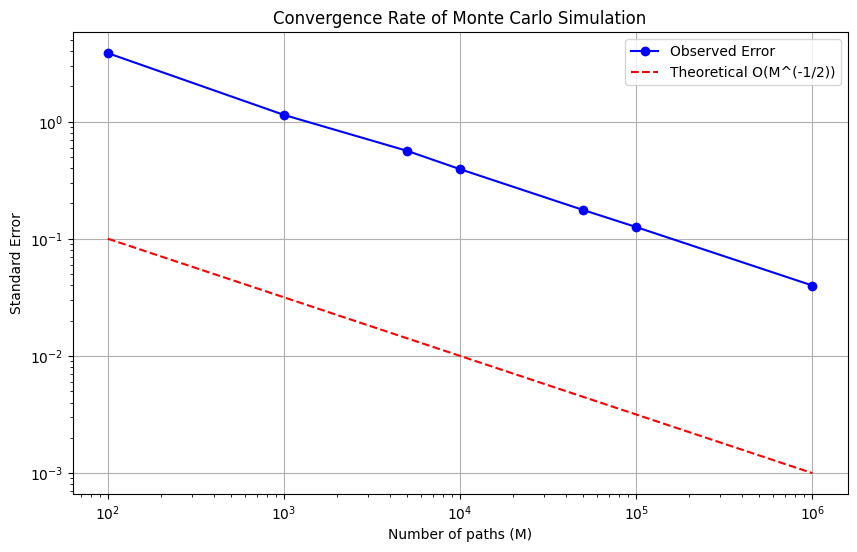

In [ ]:
# Range of M values to investigate convergence
M_values = [10, 50, 100, 500, 1000, 5000, 10000, 50000]
option_prices = []
errors = []

def analyze_convergence():
    M_values = [100, 1000, 5000, 10000, 50000, 100000, 1000000]
    N = 100  # Fixed number of time steps
    
    results = []
    for M in M_values:
        price, std_error = MonteCarloSimulation(S0, T, r, sigma, N, M, guarantee)
        results.append({
            'M': M,
            'Price': price,
            'Std Error': std_error,
            'Error': 1/np.sqrt(M)
        })
        print(f"M={M}: Price={price:.4f}, Std Error={std_error:.4f}")

    # Plot convergence
    plt.figure(figsize=(10, 6))
    M_array = np.array(M_values)
    errors = [r['Std Error'] for r in results]
    plt.loglog(M_array, errors, 'bo-', label='Observed Error')
    plt.loglog(M_array, 1/np.sqrt(M_array), 'r--', label='Theoretical O(M^(-1/2))')
    plt.xlabel('Number of paths (M)')
    plt.ylabel('Standard Error')
    plt.legend()
    plt.title('Convergence Rate of Monte Carlo Simulation')
    plt.grid(True)
    plt.show()
    
    return results

convergence_results = analyze_convergence()

**Question 2:** Re-run your MC calculation multiple times for 𝑀 = 1000 (using different seed-values for the random number generator!). Plot the empirical distribution function of the estimator 𝐸. Compare this distribution to the asymptotic approximation 𝐸 ≈ 𝑛𝔼[𝑓],Var[𝑓]/𝑀.

In [23]:
def analyze_distribution():
    M = 1000
    N = 100
    n_simulations = 1000
    estimates = []
    
    for i in range(n_simulations):
        np.random.seed(i)
        price, _ = MonteCarloSimulation(S0, T, r, sigma, N, M, K)
        estimates.append(price)
    
    # Plot histogram and normal distribution
    plt.figure(figsize=(10, 6))
    plt.hist(estimates, bins=50, density=True, alpha=0.7, label='MC Estimates')
    
    mean = np.mean(estimates)
    std = np.std(estimates)
    x = np.linspace(min(estimates), max(estimates), 100)
    plt.plot(x, stats.norm.pdf(x, mean, std), 'r-', lw=2, 
             label=f'Normal(μ={mean:.2f}, σ={std:.2f})')
    
    plt.xlabel('Price Estimate')
    plt.ylabel('Density')
    plt.title('Distribution of Monte Carlo Estimates')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mean, std


Part 3: Distribution Analysis


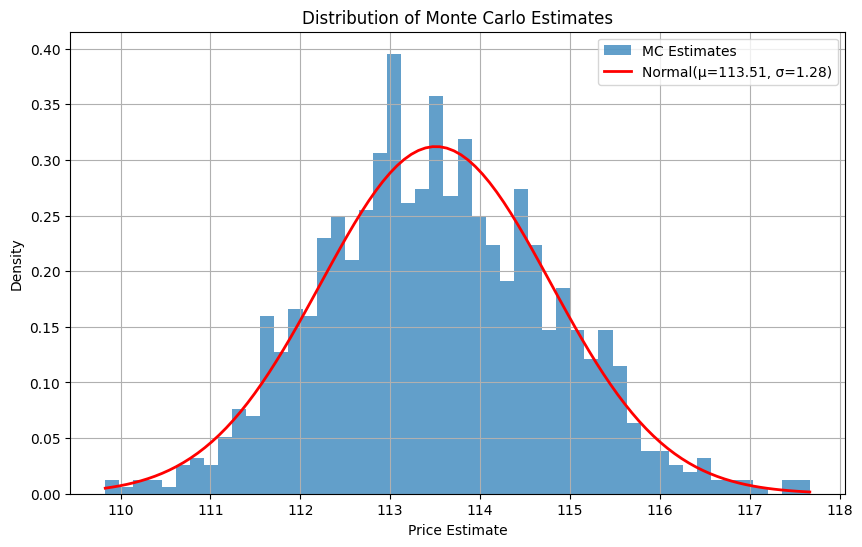

In [24]:
print("\nPart 3: Distribution Analysis")
mean, std = analyze_distribution() 

In [ ]:
# Part 4: Fixed Budget Analysis
def analyze_fixed_budget():
    budget = 1000000
    combinations = [
        (1000, 1000),
        (10000, 100),
        (100, 10000),
        (2000, 500),
        (500, 2000)
    ]
    
    results_budget = []
    for M, N in combinations:
        prices = []
        for seed in range(10):
            np.random.seed(seed)
            price, std_error = MonteCarloSimulation(S0, T, r, sigma, N, M, guarantee)
            prices.append(price)
        
        result = {
            'M': M,
            'N': N,
            'Mean Price': np.mean(prices),
            'Std Dev': np.std(prices)
        }
        results_budget.append(result)
        print(f"M={M}, N={N}: Mean Price={result['Mean Price']:.4f}, Std Dev={result['Std Dev']:.4f}")
    
    return results_budget

In [ ]:
print("\nPart 4: Fixed Budget Analysis")
budget_results = analyze_fixed_budget()



Part 4: Fixed Budget Analysis
M=1000, N=1000: Mean Price=113.4446, Std Dev=0.7988
M=10000, N=100: Mean Price=113.3918, Std Dev=0.4046
M=100, N=10000: Mean Price=112.3992, Std Dev=2.8515
M=2000, N=500: Mean Price=113.2614, Std Dev=0.7230
M=500, N=2000: Mean Price=113.7082, Std Dev=1.3569
